In [1]:
# importing libraries and dependencies

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import ipdb
import scipy
import math
from itertools import combinations
from random import choices

### Stitching

In [3]:
def warpImages(image1, image2, H):
    
    height1,width1 = image1.shape[:2]
    height2,width2 = image2.shape[:2]
    points1 = np.float32([[0,0],[0,height1],[width1,height1],[width1,0]]).reshape(-1,1,2)
    points2 = np.float32([[0,0],[0,height2],[width2,height2],[width2,0]]).reshape(-1,1,2)
    points2_ = cv2.perspectiveTransform(points2, H)
    points = np.concatenate((points1, points2_), axis=0)
    [xMini, yMini] = np.int32(points.min(axis=0).ravel() - 0.5)
    [xMaxi, yMaxi] = np.int32(points.max(axis=0).ravel() + 0.5)
    trans = [-xMini,-yMini]
    Htranslate = np.array([[1,0,trans[0]],[0,1,trans[1]],[0,0,1]]) # translate

    output = cv2.warpPerspective(image2, Htranslate.dot(H), (xMaxi-xMini, yMaxi-yMini))
    output[trans[1]:height1+trans[1],trans[0]:width1+trans[0]] = image1
    return output


### Finding inliers by geometric distance

In [4]:
def findInliers(targetPts, transPts, threshDist):
    inlierCount = 0
    inliers = []
    error = np.square(np.subtract(targetPts, transPts))
    error = np.sqrt(error.sum(axis=0))
    for i in range(len(error)):
        if(error[i]<threshDist):
            inlierCount += 1
            inliers.append(i)
    return inlierCount, inliers

### transformation using the Homography matrix

In [5]:
def transformH(H, pts):
    #pts is a 2XN matrix with N points
    #padd 1 for heterogeneuos coordinates
    pHet = np.ones((pts.shape[0]+1 , pts.shape[1]), np.float32)
    pHet[:-1, :] = pts
    transformedPtsHet = np.matmul(H,pHet)
    #each column of transformed points is 1 transformed point (x,y,z)
    #convert to heterogeneous (x/z, y/z)
    transformedPts = np.zeros((pts.shape[0] , pts.shape[1]), np.float32)
    transformedPts[0, :] = np.divide(transformedPtsHet[0,:], transformedPtsHet[2, :])
    transformedPts[1, :] = np.divide(transformedPtsHet[1,:], transformedPtsHet[2, :])
    return transformedPts

### Contructing the linear equation 2X9 matrix for each feature correspondence

In [6]:
def contructLinear(pt1, pt2):
    lin = np.zeros((2,9), np.float32)
    lin[0, :] = [-pt1[0], -pt1[1], -1, 0, 0, 0, pt1[0]*pt2[0], pt1[1]*pt2[0], pt2[0]]
    lin[1, :] = [0, 0, 0, -pt1[0], -pt1[1], -1, pt1[0]*pt2[1], pt1[1]*pt2[1], pt2[1]]
#     print(lin)
    return lin

### Computing the Homography Matrix by SVD for the given points correspondences

In [100]:
# Fnction to compute Homography
def computeH(im1_pts, im2_pts):
    #im1Pts and im2Pts are 2xn 
    #to form the A matrix for SVD
    A = np.zeros((2*len(im1_pts[0]),9), np.float32)
    for i in range(len(im1_pts[0])):
        A[2*i: 2*i+2, :] = contructLinear(im1_pts[:,i], im2_pts[:,i])
    S, U, Vt = cv2.SVDecomp(A)
    
    #choose the V that has least singular value, which is the S9, hence the 9th row in Vtranspose
    h = Vt[len(Vt)-1,:]
    if (h[len(h)-1]!=0):
        h = h*(1/h[len(h)-1])
    H = np.reshape(h, (3,3))
    
    return H
    

In [54]:
# function to convert keypoints to coordinates
def keyToCoord(keyPoints):
    coord = np.zeros((2,len(keyPoints)),np.float32)
    for i, kp in enumerate(keyPoints):
        coord[0, i] = kp.pt[0]
        coord[1, i] = kp.pt[1]
    return coord

### RANSAC algorithm to find the best Homography matrix which satisfies the most inliers

In [9]:
def RANSAC(matches, epsilon, iters):
    maxInliers = []
    #extract keypoints from pairs
    refKeys = [i[0] for i in matches]
    otherKeys = [j[1] for j in matches]
    #converting to 2D coordinates
    refPts = keyToCoord(refKeys)
    otherPts = keyToCoord(otherKeys)
    #start iterating for iters no. of times
    for m in range(iters):
        # randomly select 4 matches for finding Homography
        selectedMatches = choices(matches, k=4)
        selRefPts = keyToCoord([i[0] for i in selectedMatches])
        selOtherPts = keyToCoord([j[1] for j in selectedMatches])
        # compute Homography using the selected matches
        Homo = computeH(selOtherPts,selRefPts)
        otherTransformed = transformH(Homo, otherPts)
        inlierCount, inlierIndices = findInliers(refPts,otherTransformed, epsilon)
        if (inlierCount>len(maxInliers)):
            maxInliers = inlierIndices
    inlierPercent = len(maxInliers)*100/len(matches)
    print("max inlier percentage: ", inlierPercent)
    
    # compute the final Homography using all the inliers in the list of maxInliers found by RANSAC
    finalBestMatches = [matches[i] for i in maxInliers]
    finalRefPts = keyToCoord([i[0] for i in finalBestMatches])
    finalOtherPts = keyToCoord([i[1] for i in finalBestMatches])
    finalH = computeH(finalOtherPts, finalRefPts)
    return finalBestMatches, finalH

### Function to draw poly lines between 2 images to show good or best matches

In [97]:
def drawMatches(imgLeft, imgRight, matches):
    #draw matches with polylines function
    matchesLeft = []
    matchesRight= []
    for match in matches:
        matchesLeft.append(match[0])
        matchesRight.append(match[1])
    leftImg = cv2.drawKeypoints(imgLeft, matchesLeft, None)
    rightImg = cv2.drawKeypoints(imgRight, matchesRight, None)
    if(leftImg.shape[0]!=rightImg.shape[0]):
        leftImg = cv2.resize(leftImg, (leftImg.shape[1], rightImg.shape[0]))
    imgMatches = np.concatenate((leftImg,rightImg),axis=1)
    pts = np.zeros((len(matchesLeft),2, 2), np.int32)
    for i in range(len(matchesLeft)):
        pts[i, 0, :] = np.int32(matchesLeft[i].pt)
        pts[i, 1, 0] = np.int32(matchesRight[i].pt[0] + leftImg.shape[1])
        pts[i, 1, 1] = np.int32(matchesRight[i].pt[1])
        imgMatches = cv2.polylines(imgMatches,  np.int32([pts[i]]), 0, (0,255,0))
    return imgMatches

### The following function getGoodMatches() uses Lowe ratio to eliminate bad matches, here the ratio is 0.7 based on the pdf plot in the paper



In [11]:
def getGoodMatches(kIndMat, kDistMat, key1, key2):
    match1Kp = []
    match2Kp = []
    goodMatches = []
    goodMatchesInd = []
    for i in range(len(kDistMat)):
        if (kDistMat[i, 0] < 0.7*kDistMat[i, 1]):
            goodMatchesInd.append((i, kIndMat[i, 0]))
    for i, pair in enumerate(goodMatchesInd):
        match1Kp.append(key1[pair[0]])
        match2Kp.append(key2[pair[1]]) 
        goodMatches.append((key1[pair[0]],key2[pair[1]]))
    
    return goodMatches, match1Kp, match2Kp

### Implementing KNN from scratch. 
Function to get euclidean distances from each descriptor from 1 match to each of the other to find the K nearest matches

In [12]:
def Euclidean(mat1, mat2):
    dist = np.zeros((len(mat1),len(mat2)), np.float32)
    for i in range(len(mat1)):
        clonedMat = np.array([mat1[i],]*len(mat2))
        diffMat = np.subtract(mat2, clonedMat)
        squaredMat = np.square(diffMat)
        sqDistanceMat = squaredMat.sum(axis=1)
        dist[i] = np.sqrt(sqDistanceMat)
    
    return dist

In [13]:
def findKnn(distMat, k):
    kMinIndices = np.argpartition(distMat, k, axis = 1)[:,:k]
    kMinDist = distMat[np.arange(distMat.shape[0])[:,None], kMinIndices]
    return kMinIndices, kMinDist

In [14]:
# function for getting the key features and their descriptors
def getFeatures(img):
    sift = cv2.xfeatures2d.SIFT_create()
    #finding the key points and descriptors
    keyPoints, descriptors = sift.detectAndCompute(img, None)
    return keyPoints, descriptors

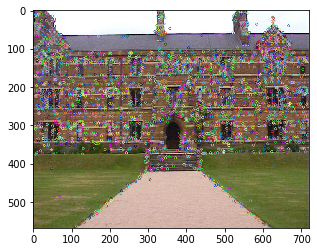

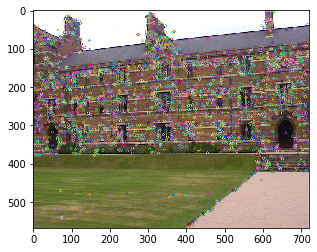

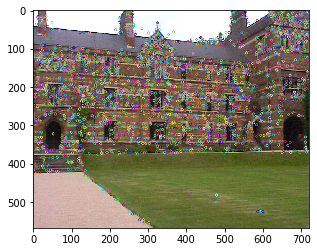

(<matplotlib.image.AxesImage at 0x21c66df02e8>, None)

In [56]:

centerImg = cv2.imread('keble_b.jpg', 1)
leftImg = cv2.imread('keble_a.jpg', 1)
rightImg = cv2.imread('keble_c.jpg', 1)

#getting the features and descriptors for each image
keyCenter, desCenter = getFeatures(centerImg)
keyLeft, desLeft = getFeatures(leftImg)
keyRight, desRight = getFeatures(rightImg)
plt.imshow(cv2.cvtColor(cv2.drawKeypoints(centerImg, keyCenter, None), cv2.COLOR_BGR2RGB)), plt.show()
plt.imshow(cv2.cvtColor(cv2.drawKeypoints(leftImg, keyLeft, None), cv2.COLOR_BGR2RGB)), plt.show()
plt.imshow(cv2.cvtColor(cv2.drawKeypoints(rightImg, keyRight, None), cv2.COLOR_BGR2RGB)),plt.show()

Calculate the euclidean distances from each feature descriptor in 1 image with every feauture in other image

In [16]:
#Do not run multiple times
distanceMat = Euclidean(desCenter, desLeft)

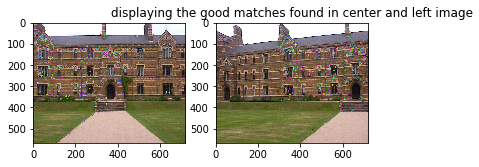

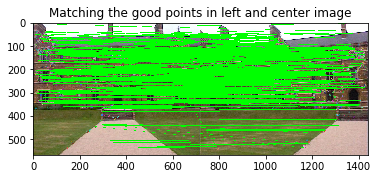

(<matplotlib.image.AxesImage at 0x21c1206b5f8>,
 Text(0.5, 1, 'Matching the good points in left and center image'),
 None)

In [68]:
knnIndex, knnDist = findKnn(distanceMat, 2)

# put this in the getMatches function
goodMatches, centerMatch, leftMatch = getGoodMatches(knnIndex, knnDist, keyCenter, keyLeft)

#draw matches with polylines function
imgMatches = drawMatches(centerImg, leftImg, goodMatches)
cv2.imwrite('goodMatchesByLowe.jpg', imgMatches)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(cv2.cvtColor(cv2.drawKeypoints(centerImg, centerMatch, None), cv2.COLOR_BGR2RGB))
axarr[1].imshow(cv2.cvtColor(cv2.drawKeypoints(leftImg, leftMatch, None), cv2.COLOR_BGR2RGB))
plt.title("displaying the good matches found in center and left image")
plt.show()
cv2.imwrite('goodCenterL.jpg', cv2.drawKeypoints(centerImg, centerMatch, None))
cv2.imwrite('goodLeftC.jpg', cv2.drawKeypoints(leftImg, leftMatch, None))

plt.imshow(cv2.cvtColor(imgMatches, cv2.COLOR_BGR2RGB)), plt.title('Matching the good points in left and center image'), plt.show()

In [21]:
BestMatches, estimatedH = RANSAC(goodMatches, 5, 5000)

max inlier percentage:  88.38862559241706


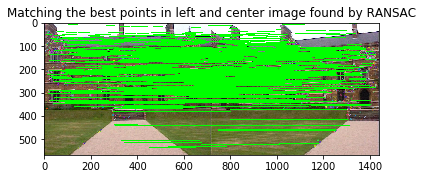

(<matplotlib.image.AxesImage at 0x21c131ab9e8>,
 Text(0.5, 1, 'Matching the best points in left and center image found by RANSAC'),
 None)

In [71]:
bestMatchesImg = drawMatches(centerImg, leftImg, BestMatches)
cv2.imwrite('bestMatchesLC.jpg', bestMatchesImg)
plt.imshow(cv2.cvtColor(bestMatchesImg, cv2.COLOR_BGR2RGB)), plt.title('Matching the best points in left and center image found by RANSAC'), plt.show()


(<matplotlib.image.AxesImage at 0x21c127e1be0>,
 Text(0.5, 1.0, 'stitched left and center image'))

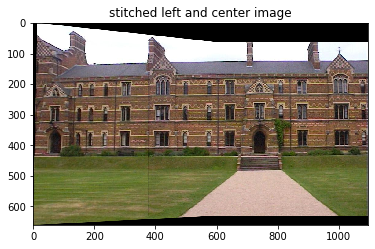

In [72]:
warpedImgLeftCenter = warpImages(centerImg,leftImg,estimatedH)
cv2.imwrite('Warped_Left_and_Center.jpg', warpedImgLeftCenter)
plt.imshow(cv2.cvtColor((warpedImgLeftCenter), cv2.COLOR_BGR2RGB)), plt.title('stitched left and center image')

This is the warped image of center with left

### Now, doing the entire process with this warped image with the right image to generate the final mosiac

In [41]:
keyCenterLeft, desCenterLeft = getFeatures(warpedImgLeftCenter)

In [43]:
#Do not run multiple times
distanceMatCLR = Euclidean(desCenterLeft, desRight)

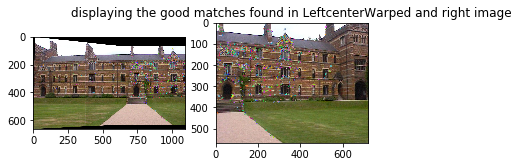

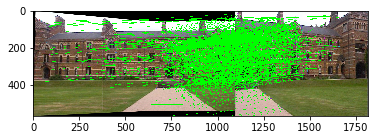

In [99]:
knnIndexCLR, knnDistCLR = findKnn(distanceMatCLR, 2)

# put this in the getMatches function
goodMatchesCLR, LcenterMatch, rightMatch = getGoodMatches(knnIndexCLR, knnDistCLR, keyCenterLeft, keyRight)

#draw matches with polylines function
imgMatchesCLR = drawMatches(warpedImgLeftCenter, rightImg, goodMatchesCLR)
cv2.imwrite('goodMatchesByLoweLCenterRight.jpg', imgMatchesCLR)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(cv2.cvtColor(cv2.drawKeypoints(warpedImgLeftCenter, LcenterMatch, None), cv2.COLOR_BGR2RGB))
axarr[1].imshow(cv2.cvtColor(cv2.drawKeypoints(rightImg, rightMatch, None), cv2.COLOR_BGR2RGB))
plt.title("displaying the good matches found in LeftcenterWarped and right image")
plt.show()
plt.imshow(cv2.cvtColor(imgMatchesCLR, cv2.COLOR_BGR2RGB))
plt.show()

In [103]:
BestMatches_CLR, estimatedH_CLR = RANSAC(goodMatchesCLR, 5, 10000)

max inlier percentage:  61.02620087336245


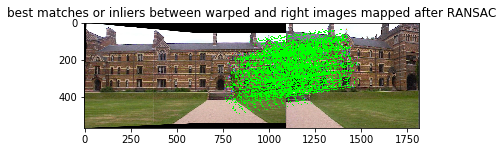

(<matplotlib.image.AxesImage at 0x21c13103f98>,
 Text(0.5, 1, 'best matches or inliers between warped and right images mapped after RANSAC'),
 None)

In [105]:
imgBestMatchesCLR = drawMatches(warpedImgLeftCenter, rightImg, BestMatches_CLR)
cv2.imwrite('bestMatchesByRANSACLCenterRight.jpg', imgBestMatchesCLR)
plt.imshow(cv2.cvtColor((imgBestMatchesCLR), cv2.COLOR_BGR2RGB)), plt.title('best matches or inliers between warped and right images mapped after RANSAC'), plt.show()

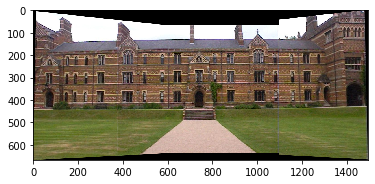

In [53]:
warpedImgLeftCenterRight = warpImages(warpedImgLeftCenter, rightImg, estimatedH_CLR)
cv2.imwrite('Warped_complete.jpg', warpedImgLeftCenterRight)
plt.imshow(cv2.cvtColor((warpedImgLeftCenterRight), cv2.COLOR_BGR2RGB))